# Mini Project: Binary classification with Logistic Regression

Your goal is to use your previous experience in order to build a simple binary classifier for Text vs. Non-text classification. Then apply it to classify image patches.

The roadmap is as follows:

* Load and display images
* Import the train/test datasets
* Train and Run the Logistic Regression classifier using two different image features:
 * Raw pixels
 * Histograms of grey values
* Evaluate and compare the classifier results using different evaluation measures
* Use your patch classifier in a sliding window scheme

## Preliminary

Load images, convert to numpy arrays, reshape.

In [1]:
import imageio

#Load an image example
img = imageio.imread('./img_A.pgm')

type(img),img.ndim, img.shape, img.dtype

(imageio.core.util.Array, 2, (32, 32), dtype('uint8'))

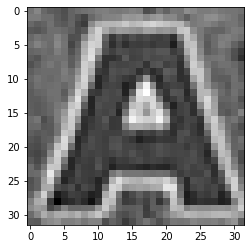

In [2]:
import matplotlib.pyplot as plt #matplotlib plotting library

# Display an image
plt.imshow(img, cmap=plt.cm.gray)

In [3]:
import numpy as np
#reshape image array to a vector (1D array)
img = np.reshape(img,-1)

type(img),img.ndim, img.shape, img.dtype

(imageio.core.util.Array, 1, (1024,), dtype('uint8'))

## Data acquisition (Optional)

This part of the notebook deals with loading images from your hard disk and convert them to NumPy arrays. This is going to be our dataset. Images are stored as pgm files but may be in any other image format. 

Since we are going to read near 12000 files from disk, it may take around 20 minutes. If you prefer you can jump to the next section of the notebook and load directly the **raw_pixels_dataset_5980.pklz** file, which already contains the NumPy arrays for the entire dataset. The code is here just in case you are curious about how to convert image files into NumPy arrays, and how the **raw_pixels_dataset_5980.pklz** has been created.

To execute this part of the notebook you must download the **scene_text_dataset.zip** (<font color='red'>~140 Mb</font>) file from the Campus Virtual site and decompress it in the same directory as this python notebook.


In [ ]:
from os import listdir #now we will load all images in a given directory

datapath = 'data/characters/icdar/img_ICDAR_train/'

char_raw_pixels = np.array([ np.reshape(imageio.imread(datapath+f),-1) for f in listdir(datapath) ])
char_raw_pixels = np.reshape(char_raw_pixels,[-1,1024])

char_raw_pixels.shape

In [ ]:
datapath = 'data/background/train/'

bg_raw_pixels = np.array([ np.reshape(imageio.imread(datapath+f),-1) for f in listdir(datapath) ])
bg_raw_pixels = np.reshape(bg_raw_pixels,[-1,1024])

bg_raw_pixels.shape

In [ ]:
# We want a balanced dataset so we take only the first 5980 background samples
bg_raw_pixels = bg_raw_pixels[0:5980,:]
bg_raw_pixels.shape

In [ ]:
#Visualize. Just to be sure the data is correct

im = char_raw_pixels[1,:]
im = np.reshape(im,[32,32])

plt.subplot(1, 2, 1)
plt.imshow(im, cmap=plt.cm.gray)

im = bg_raw_pixels[1,:]
im = np.reshape(im,[32,32])

plt.subplot(1, 2, 2)
plt.imshow(im, cmap=plt.cm.gray)

In [ ]:
train_features = np.append(char_raw_pixels,bg_raw_pixels, axis=0)

char_labels = np.ones([char_raw_pixels.shape[0],1])
bg_labels   = np.zeros([bg_raw_pixels.shape[0],1])

train_labels = np.append(char_labels, bg_labels)

train_features.shape, train_labels.shape

In [ ]:
#we now do the same for test data

datapath = 'data/characters/icdar/img_ICDAR_test/'

char_raw_pixels = np.array([ np.reshape(imageio.imread(datapath+f),-1) for f in listdir(datapath) ])
char_raw_pixels = np.reshape(char_raw_pixels,[-1,1024])

char_raw_pixels.shape

In [ ]:
datapath = 'data/background/test/'

bg_raw_pixels = np.array([ np.reshape(imageio.imread(datapath+f),-1) for f in listdir(datapath) ])
bg_raw_pixels = np.reshape(bg_raw_pixels,[-1,1024])

bg_raw_pixels.shape

In [ ]:
test_features = np.append(char_raw_pixels,bg_raw_pixels, axis=0)

char_labels = np.ones([char_raw_pixels.shape[0],1])
bg_labels   = np.zeros([bg_raw_pixels.shape[0],1])

test_labels = np.append(char_labels, bg_labels)

test_features.shape, test_labels.shape

In [ ]:
#Now we can save all our data as python serialized data, so we do not need to read again image
# files the next time we want execute our classification code

import pickle #module for serialization of python object structure
import gzip   #we can compress our data directly when writting data to a file

with gzip.open('./raw_pixels_dataset_5980.pklz','wb') as f:
 pickle.dump((train_labels,train_features,test_labels,test_features),f,pickle.HIGHEST_PROTOCOL)


## Method 1: Classification using raw pixels as features

In the following we will try how good are the raw pixel features to automatically classify the different classes.

We are going to evaluate classification using the Logistic regression method. 

In [4]:
# load the data
import pickle
import gzip

with gzip.open('./raw_pixels_dataset_5980.pklz','rb') as f:
 (train_labels,train_features,test_labels,test_features) = pickle.load(f)

print (train_features.shape)
print (test_features.shape)

(11960, 1024)
(10396, 1024)


## Using the Logistic regression classifier

Let's recover the logistic regression code we have defined: 
Note: We have used the principal Gradient Descent algorithm for optimization and learning. Also we have added the Lasso regression (L1 regularization) term for the cost function. We have used this cost function for the rest of the approaches we have used for this project.   

In [5]:
def sigmoid(X):
    '''
    Computes the Sigmoid function of the input argument X.
    '''
    return 1.0/(1+np.exp(-X))

def GradientDescent_logistic_reg(x,y,max_iterations=2500, alpha=0.1, reg_lambda = 1):
    
    m,n = x.shape # number of samples, number of features

    # y must be a column vector
    y = y.reshape(m,1)
    
    #initialize the parameters
    theta = np.ones(shape=(n,1)) 
    
    # Repeat until convergence (or max_iterations)
    for iteration in range(max_iterations):
        h = sigmoid(np.dot(x,theta))
        error = (h-y)
        gradient = np.dot(x.T , error) / m  + reg_lambda * theta / m   # ADDED THE REGULARISATION TERM FOR COST FUNCTION
        theta = theta - alpha*gradient
    return theta

def classifyVector(X, theta):
    '''
    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    '''
    prob = sigmoid(sum(np.dot(X,theta)))
    if prob > 0.5: return 1.0
    else: return 0.0

<font color=blue>Use logistic regression to learn a classifier over your training set, using the original pixel data as input</font>

In [11]:
# YOUR CODE HERE

print(train_features.shape)

#Logistic Regression gradient descent optimization
w = GradientDescent_logistic_reg(train_features, train_labels, max_iterations=100, alpha = 0.1, reg_lambda = 1)

H = [classifyVector(train_features[i,:],w) for i in range(train_features.shape[0])]
print ("Training Accuracy : {0}".format(str(float(np.sum(H == train_labels)) / train_labels.shape[0])))




(11960, 1024)
Training Accuracy : 0.5


c:\program files\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


**Inference** : We observe that the above method with raw pixels as features give us a meagre training accuracy of 50 % and computationally more expensive too. Also this is not the best approach for classifying text and non-text regions as we have discussed in the next cell. So we move on to a better feature extraction technique for improving our model, which we define as 'handcrafted feature extractor' with histogram of grey values.      

## Method 2: Handcrafted feature extraction with Histogram of intensity values

We have seen how using the raw pixels is not a good idea. Intuitively there are two main reasons for the bad performance of our classifier: first, we do not have enough data to train in such a high dimensional space (1024-D), second, the raw pixels do not have enough discriminative power to effectively discriminate over the Text and Non-text examples in our dataset. Notice that a simple 1-pixel shift in one of the examples may produce a very different feature vector.

In Computer Vision (and in Pattern Recognition in general), feature extraction is a procedure to extract pieces of information which are relevant for solving the computational task at hand. There is a large tradition in designing handcrafted features, that incorporate class prior knowledge, to solve specific problems.

In this part of the notebook we are going to extract simple features: histograms of the intensity values of our images. The intuition is that in text image patches we expect to find bi-level histograms (two opposite dominant colors), because text is by design written with high contrast to its background.

Then we will evaluate how good those features are for  automatically classifying between the two classes (Text/Non-text) using Logistic Regression.


In [12]:
#For each example we compute the histogram of grey intensity values

new_train_features = np.zeros([train_features.shape[0],8])
for i in range(train_features.shape[0]):
    new_train_features[i,:] = np.histogram(train_features[i,:],8)[0]
    new_train_features[i,:] /= np.sum(new_train_features[i,:]) #Histogram normalization
    
new_test_features = np.zeros([test_features.shape[0],8])
for i in range(test_features.shape[0]):
    new_test_features[i,:] = np.histogram(test_features[i,:],8)[0]
    new_test_features[i,:] /= np.sum(new_test_features[i,:]) #Histogram normalization
    
new_train_features.shape, new_test_features.shape

((11960, 8), (10396, 8))

<BarContainer object of 8 artists>

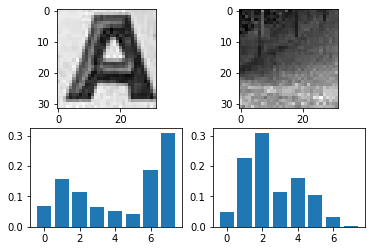

In [13]:
#Visualize the histograms of positive/negative samples

plt.subplot(2, 2, 1)
plt.imshow(np.reshape(train_features[1,:],[32,32]), cmap=plt.cm.gray)

plt.subplot(2, 2, 2)
plt.imshow(np.reshape(train_features[5981,:],[32,32]), cmap=plt.cm.gray)

bins = [0,1,2,3,4,5,6,7]

plt.subplot(2, 2, 3)
plt.bar(bins, new_train_features[1,:], align='center')

plt.subplot(2, 2, 4)
plt.bar(bins, new_train_features[5981,:], align='center')

#print train_labels[1],train_labels[5981]

**Inference**: We then use the Logistic regression classifier with simple gradient descent algorithm using the handcrafted features we already computed in the previous cells.   

In [16]:
# YOUR CODE HERE

print(new_train_features.shape)

#Logistic Regression gradient descent optimization
w = GradientDescent_logistic_reg(new_train_features, train_labels, max_iterations=10000, alpha = 0.1, reg_lambda = 1)

H = [classifyVector(new_train_features[i,:],w) for i in range(new_train_features.shape[0])]
print ("Training Accuracy : {0}".format(str(float(np.sum(H == train_labels)) / train_labels.shape[0])))

H = [classifyVector(new_test_features[i,:],w) for i in range(new_test_features.shape[0])]
print ("testing Accuracy : {0}".format(str(float(np.sum(H == test_labels)) / test_labels.shape[0])))



(11960, 8)
Training Accuracy : 0.737876254180602
testing Accuracy : 0.7501923816852636


**BINGO!!! With the use of Histograms of intensity values we have improved the performance of our classifier by more than 20%!**

Notice that this is a very simple feature extraction process, that is not really used in this way in state-of-the-art algorithms. In fact the proposed features are really quite weak (as can be seen with the obtained results). However, the idea here is to take conscience that the design of handcrafted features is a possible way of improving the discrimination power of our classifiers.

This experiment also serves to introduce the topic of next Practical (PR2), where we are going to see how it is possible to automatically learn powerful features in an unsupervised way from our training data.

**Next step**:
Making use the Histogram of intensity values features, evaluate the Precision and Recall measures at different operation points of the classifier. This can be done by changing the 0.5 decision threshold in the ClassifyVector function to a range of values between 0 and 1. Plot the obtained Precision/Recall curve (PR-curve) and analyse it.
We use the Precision-Recall (PR) curve to visualize the classifier performance because we have a highly imbalanced distribution between text and non-text regions in our dataset. So we use the P-R curve instead of ROC curve for the analysis. 

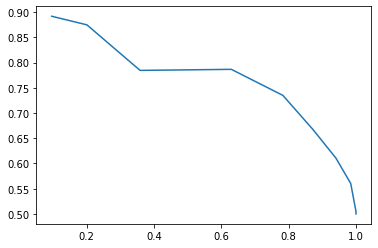

In [22]:
# YOUR CODE HERE

def classifyVector_threshold(X, theta, threshold):
    '''
    Evaluate the Logistic Regression model h(x) with theta parameters,
    and returns the predicted label of x.
    '''
    prob = sigmoid(sum(np.dot(X,theta)))
    if prob > threshold: return 1.0
    else: return 0.0

x = np.linspace(0.0, 1.0, 10)
y = np.zeros((x.shape[0],2))

for i, threshold in enumerate(x):
    threshold = float(i)/10.0
    H = [classifyVector_threshold(new_test_features[i,:],w,threshold) for i in range(new_test_features.shape[0])]
    TP = float(np.sum((H == test_labels) & (test_labels == 1))) / test_labels.shape[0]
    TN = float(np.sum((H == test_labels) & (test_labels == 0))) / test_labels.shape[0]
    FP = float(np.sum((H != test_labels) & (test_labels == 0))) / test_labels.shape[0]
    FN = float(np.sum((H != test_labels) & (test_labels == 1))) / test_labels.shape[0]
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    y[i,0] = precision
    y[i,1] = recall

plt.figure()
plt.plot(y[:,1], y[:,0])
plt.show()

**Inference**: The Precision-Recall (P-R) curve from the above results help us to infer we have a reasonably good classification performance with the above method. We have managed to optimize the prediction errors in most cases. 

## Method 3: Using Sliding Window with our Text vs. Non-text classifier

Sliding Window is a common Computer Vision technique used to apply patch-based classifiers into full-size images. The basic idea is to exhaustively evaluate the classifier response in "all" possible sub-windows of the input image.

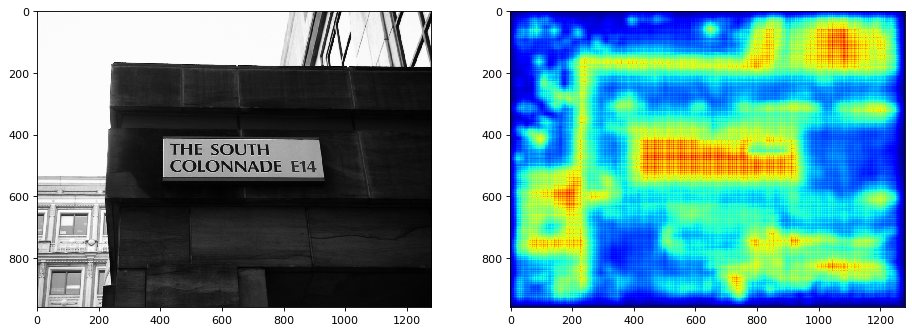

In [24]:
from PIL import Image

img = Image.open("img_scene.jpg")
#img.show()

img = np.array(img)

#pylab.rcParams['figure.figsize'] = 14, 10.5  # changes the default image size for the notebook
plt.figure(num=None, figsize=(14, 10.5), dpi=80, facecolor='w', edgecolor='k')

# Load an image and plot it
#img = imageio.imread('img_scene.jpg')
plt.subplot(1, 2, 1)
plt.imshow(img, cmap=plt.cm.gray)

detection_map = np.zeros(shape=img.shape)

win_sizes = (32,64,96)
win_step  = 0.2

for size in win_sizes:
  for x in range(0,img.shape[1]-size,int(size*win_step)):
    for y in range(0,img.shape[0]-size,int(size*win_step)):
        window = img[y:y+size,x:x+size]
        window = np.array(Image.fromarray(window).resize(size = (32,32), resample = Image.BILINEAR))
        raw_pixels = np.reshape(window,[-1,1024])
        hist_feature = np.histogram(raw_pixels,8)[0]
        hist_feature = hist_feature.astype(np.float32)
        hist_feature /= np.sum(hist_feature.T)
        prob = sigmoid(sum(np.dot(hist_feature,w)))
        detection_map[y:y+size,x:x+size] += 255*prob
        
plt.subplot(1, 2, 2)
plt.imshow(detection_map,cmap=plt.cm.jet)


## Open Exercise

<font color=blue>Propose and implement an improvement, or an extra evaluation analysis, for our Text vs. Non-text classifier in its current status.</font>

Some ideas (not a closed list):

* Implement the Stochastic Gradient Descent algorithm. Show how it improves the training time performance.

* Use cross-validation to tune the meta-parameters (max_iterations and learning rate $\alpha$) of Gradient Descent. 

* Other optimization algorithms?

* Evaluate the Test Accuracy as a function of the number of training examples ($m$).

* Use Histogram of Oriented Gradients (HOG) image features. http://scikit-image.org/docs/dev/auto_examples/plot_hog.html

* Improve the Histogram features. E.g. Evaluate the effect of histogram size. Try different number of bins and compare the obatined results (show precision, recall, accuracy). Can you improve the current Test Accuracy? What is the best accuracy you can reach?

* Zoning: compute NxN grey level histograms in a N by N grid of cells over the image patch, and concatenate them to create a new feature.


## Method 4 : Use the Histogram of Oriented Gradients (HOG) image features 

Firstly, visualize the histograms of positive/negative samples by extracting features using the HOG feature extractor.  

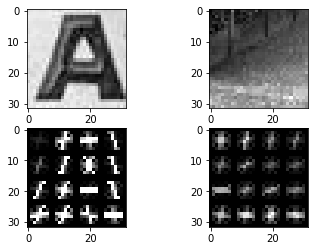

In [28]:
# YOUR CODE HERE

import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

image1 = np.reshape(train_features[1,:],[32,32])
plt.subplot(2, 2, 1)
plt.imshow(image1, cmap=plt.cm.gray)

image2 = np.reshape(train_features[5981,:],[32,32])
plt.subplot(2, 2, 2)
plt.imshow(image2, cmap=plt.cm.gray)

plt.subplot(2, 2, 3)
fd, hog_image = hog(image1, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

plt.subplot(2, 2, 4)
fd, hog_image = hog(image2, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

**Using the HOG features and computing the histogram of grey intensity values**

In [34]:
#For each example we compute the histogram of grey intensity values

orientations = 8
pixels_per_cell = 8
cells_per_image = 4
hog_train_features = np.zeros([train_features.shape[0],orientations*cells_per_image*cells_per_image])
for i in range(train_features.shape[0]):
    image = np.reshape(train_features[i,:],[32,32])
    fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
    hog_train_features[i,:] = fd
    
hog_test_features = np.zeros([test_features.shape[0],orientations*cells_per_image*cells_per_image])
for i in range(test_features.shape[0]):
    image = np.reshape(test_features[i,:],[32,32])
    fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
    hog_test_features[i,:] = fd
    
hog_train_features.shape, hog_test_features.shape

((11960, 128), (10396, 128))

In [35]:
print(hog_train_features.shape)

#Logistic Regression gradient descent optimization
w = GradientDescent_logistic_reg(hog_train_features, train_labels, max_iterations=10000, alpha = 0.1, reg_lambda = 1)

H = [classifyVector(hog_train_features[i,:],w) for i in range(hog_train_features.shape[0])]
print ("Training Accuracy : {0}".format(str(float(np.sum(H == train_labels)) / train_labels.shape[0])))

H = [classifyVector(hog_test_features[i,:],w) for i in range(hog_test_features.shape[0])]
print ("testing Accuracy : {0}".format(str(float(np.sum(H == test_labels)) / test_labels.shape[0])))


(11960, 128)
Training Accuracy : 0.9242474916387959
testing Accuracy : 0.9183339746056175


**Final Inference**: 


* **BINGO!!!Compared with the Histograms of intensity values, the Histogram of Oriented Gradients (HOG) image features improved the performance of our classifier by almost 20% again!!**

* **In this case, HOG is really a better feature extraction method than the raw data and the Histograms of intensity values. We managed to get a almost perfect model with the Logistic Regression and simple gradient descent with a high classification accuracy of 92%.**

* **Further improvement in classifier performance using the Stochastic Gradient Descent (SGD) optimization instead of simple gradient descent can be done.**  

